In [264]:
import eurostat
from mesa import Model, Agent, DataCollector
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import geopandas as gpd
import geodatasets
from iso3166 import countries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests, zipfile, io, os
from scipy.stats import pearsonr
from adjustText import adjust_text

In [20]:
# Preprocessing constants
TARGET_AGE = "TOTAL"
TARGET_SEX = "T" # Total
TARGET_MEAN_INCOME_UNIT = "EUR" # Unit of measure for income: Euro
TARGET_MEAN_INCOME_INDIC = "MEI_E" # Income and living conditions indicator: Mean equivalised net income
TARGET_POVERTY_UNIT = "PC"
TARGET_POVERTY_INDIC = "LI_R_M60"#LI_R_MD50
TARGET_HOUSING_INCOME_GROUP = "TOTAL"
TARGET_HOUSING_TYPE = "TOTAL"
TARGET_UNEMPLOYMENT_AGES = "Y15-74"
TARGET_UNEMPLOYMENT_UNIT = "PC_POP"#PC_ACT

# Simulation constants
NUM_STEPS = 100
NUM_AGENTS_PER_REGION = 20
SEED = 15
SHIFT_RATE = 0.2
NOISE_STD = 0.05

## Preprocessing Routines for additional Plots
Dataset filtering, brining df into long format and funktions for filtering one year or more years

In [ ]:
def melt_eurostat_df(df):
    non_eu_entities = ['EU27_2020', 'EA20', 'EA18', 'EA19', 'EU27_2007', 'EU28','TR']  
    year_cols = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    id_vars = [col for col in df.columns if col not in year_cols]
    df_long = df.melt(id_vars=id_vars, var_name="year", value_name="value")
    df_long = df_long[df_long["year"].apply(lambda x: str(x).isdigit())]
    df_long["year"] = df_long["year"].astype(int)
    for col in id_vars:
        if "geo" in col.lower():
            df_long.rename(columns={col: "geo"}, inplace=True)
            df_long = df_long[~df_long["geo"].isin(non_eu_entities)]  
    return df_long

def get_data_for_year(df_long, year):
    df = df_long.copy()
    df = df[
        (df["year"] == year)
    ]
    return df

def get_data_for_years(df_long, year1, year2):
    df = df_long.copy()
    df = df[
        (df["year"] >= year1) &
        (df["year"] <= year2)
    ]
    return df


df_income_long = melt_eurostat_df(df_orig_mean_median_income)
df_income_long = df_income_long[
        (df_income_long["age"] == TARGET_AGE) &
        (df_income_long["sex"] == TARGET_SEX) &
        (df_income_long["unit"] == TARGET_MEAN_INCOME_UNIT) &
        (df_income_long["indic_il"] == TARGET_MEAN_INCOME_INDIC)
]
df_income_long["iso_a3"] = df_income_long["geo"].map(alpha2_to_alpha3)

df_gini_long = melt_eurostat_df(df_orig_gini_coefficient)
df_gini_long = df_gini_long[(df_gini_long["age"] == TARGET_AGE)]
df_gini_long["iso_a3"] = df_gini_long["geo"].map(alpha2_to_alpha3)
df_gini_long = df_gini_long.rename(columns={"value": "gini"})

df_poverty_long = melt_eurostat_df(df_orig_at_risk_of_poverty)
df_poverty_long = df_poverty_long[
   (df_poverty_long["sex"] == TARGET_SEX) &
   (df_poverty_long["age"] == TARGET_AGE) &
   (df_poverty_long["indic_il"] == TARGET_POVERTY_INDIC) &
   (df_poverty_long["unit"] == TARGET_POVERTY_UNIT)]
df_poverty_long["iso_a3"] = df_poverty_long["geo"].map(alpha2_to_alpha3)
df_poverty_long = df_poverty_long.rename(columns={"value": "pov"})

df_costs_long = melt_eurostat_df(df_orig_household_cost_shares)
df_costs_long = df_costs_long[
        (df_costs_long["hhtyp"] == TARGET_HOUSING_TYPE) &
        (df_costs_long["incgrp"] == TARGET_HOUSING_INCOME_GROUP) &
        (df_costs_long["unit"] == TARGET_POVERTY_UNIT)]
df_costs_long["iso_a3"] = df_costs_long["geo"].map(alpha2_to_alpha3)
df_costs_long = df_costs_long.rename(columns={"value": "cost_share"})

df_unemp_long = melt_eurostat_df(df_orig_unemployment_rate)
df_unemp_long = df_unemp_long[
    (df_unemp_long["age"] == TARGET_UNEMPLOYMENT_AGES) &
    (df_unemp_long["sex"] == TARGET_SEX) &
    (df_unemp_long["unit"] == TARGET_UNEMPLOYMENT_UNIT)]
df_unemp_long["iso_a3"] = df_unemp_long["geo"].map(alpha2_to_alpha3)
df_unemp_long = df_unemp_long.rename(columns={"value": "unemp"})

## Load Europe Map
Basic function to load map of europe and do a country mapping to 3 chars

In [286]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
extract_dir = "ne_admin_0"

if not os.path.exists(extract_dir):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)

world = gpd.read_file(f"{extract_dir}/ne_110m_admin_0_countries.shp")
europe = world[
    (world["CONTINENT"] == "Europe") &
    (world["NAME"] != "Russia")
]

# Mapping from EU country codes to ISO A3
alpha2_to_alpha3 = {
    "AL": "ALB", "AT": "AUT", "BE": "BEL", "BG": "BGR", "CH": "CHE", "CY": "CYP",
    "CZ": "CZE", "DE": "DEU", "DK": "DNK", "EE": "EST", "EL": "GRC", "ES": "ESP",
    "FI": "FIN", "FR": "FRA", "HR": "HRV", "HU": "HUN", "IE": "IRL", "IS": "ISL",
    "IT": "ITA", "LT": "LTU", "LU": "LUX", "LV": "LVA", "MT": "MLT", "NL": "NLD",
    "NO": "NOR", "PL": "POL", "PT": "PRT", "RO": "ROU", "SE": "SWE", "SI": "SVN",
    "SK": "SVK", "TR": "TUR", "UK": "GBR", "RS": "SRB", "ME": "MNE", "MK": "MKD"
}

# Additional Plots
## Income related plots
Following plot shows the available income (income reduced by cost percentage for living)

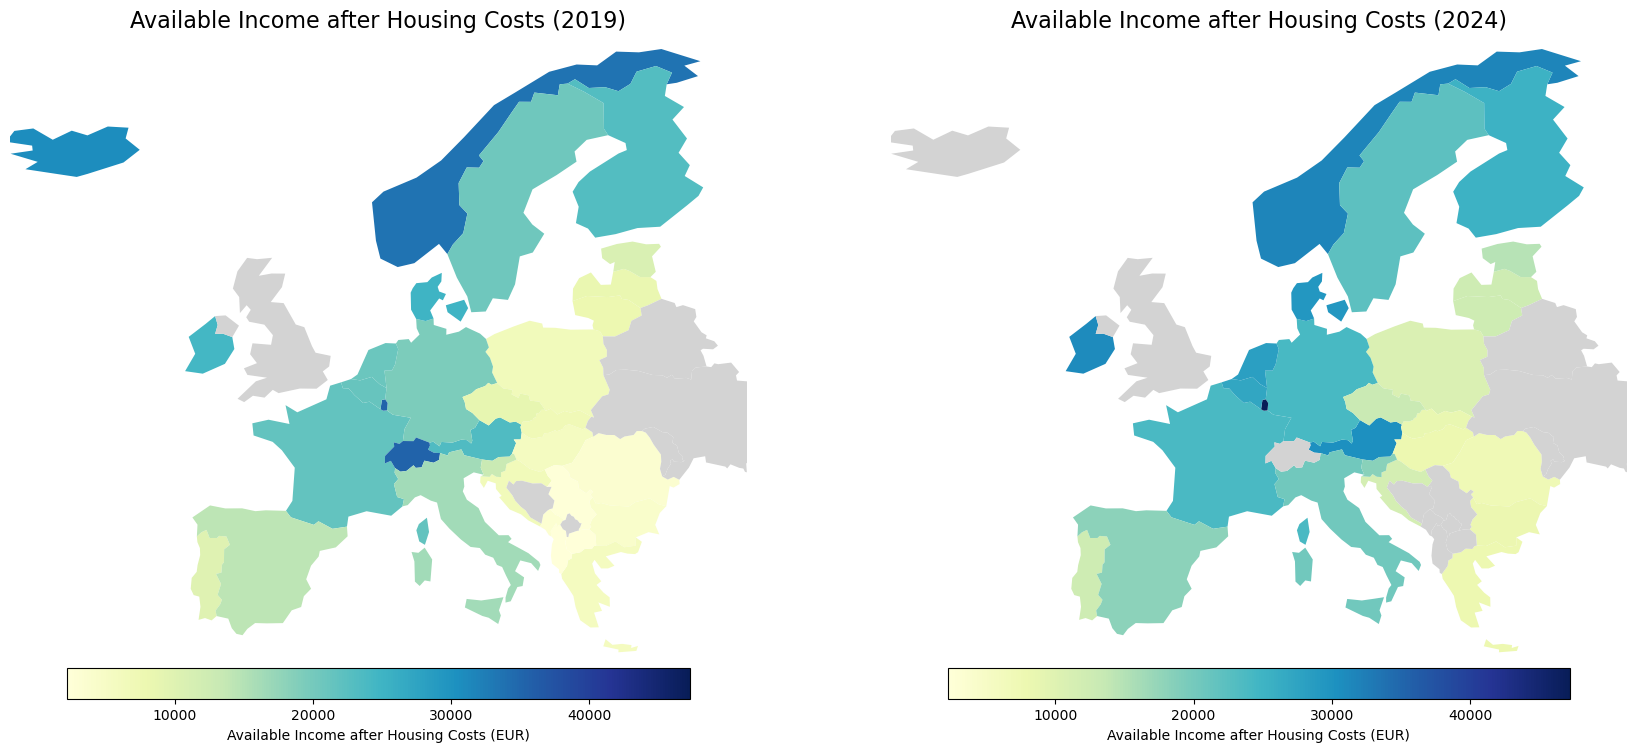

In [334]:
def merge_income_and_cost(income_df, cost_df):
    df = income_df.merge(cost_df[["iso_a3", "cost_share"]], on="iso_a3", how="left")
    df["available_income"] = df["value"] * (1 - df["cost_share"] / 100)
    return df

# Combine and merge data for 2019 and 2024
df_income_1 = merge_income_and_cost(get_data_for_year(df_income_long, 2019), get_data_for_year(df_costs_long, 2019))
df_income_2 = merge_income_and_cost(get_data_for_year(df_income_long, 2024), get_data_for_year(df_costs_long, 2024))


combined_values = pd.concat([df_income_1["available_income"], df_income_2["available_income"]])
vmin = combined_values.min()
vmax = combined_values.max()


map_1 = europe.merge(df_income_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_income_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="available_income",
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cmap="YlGnBu",
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Available Income after Housing Costs (EUR)",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Available Income after Housing Costs ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.savefig("available_income_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### Correlation for income and costs

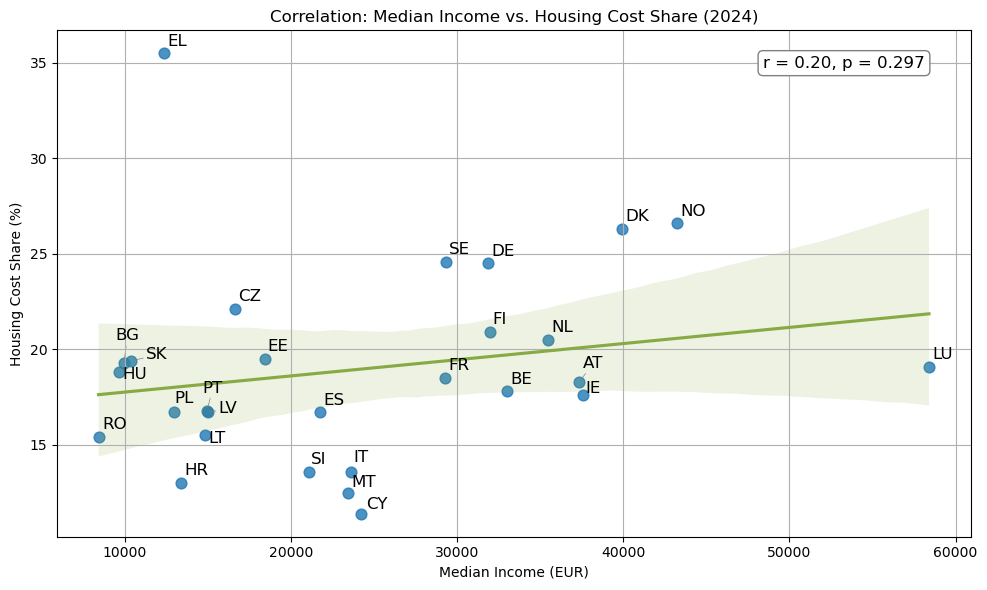

In [316]:
def merge_income_and_cost(income_df, cost_df):
    df = income_df.merge(cost_df[["iso_a3", "cost_share"]], on="iso_a3", how="inner")
    df["available_income"] = df["value"] * (1 - df["cost_share"] / 100)
    return df

df_income_1 = merge_income_and_cost(get_data_for_year(df_income_long, 2024), get_data_for_year(df_costs_long, 2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["value"], df_income_1["cost_share"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="value", y="cost_share", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["value"], row["cost_share"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Median Income vs. Housing Cost Share ({year})")
plt.xlabel("Median Income (EUR)")
plt.ylabel("Housing Cost Share (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("corr_income_costs_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### Correlation Income vs. Gini
Following plot shows the correlaction beween income and gini index in 2024

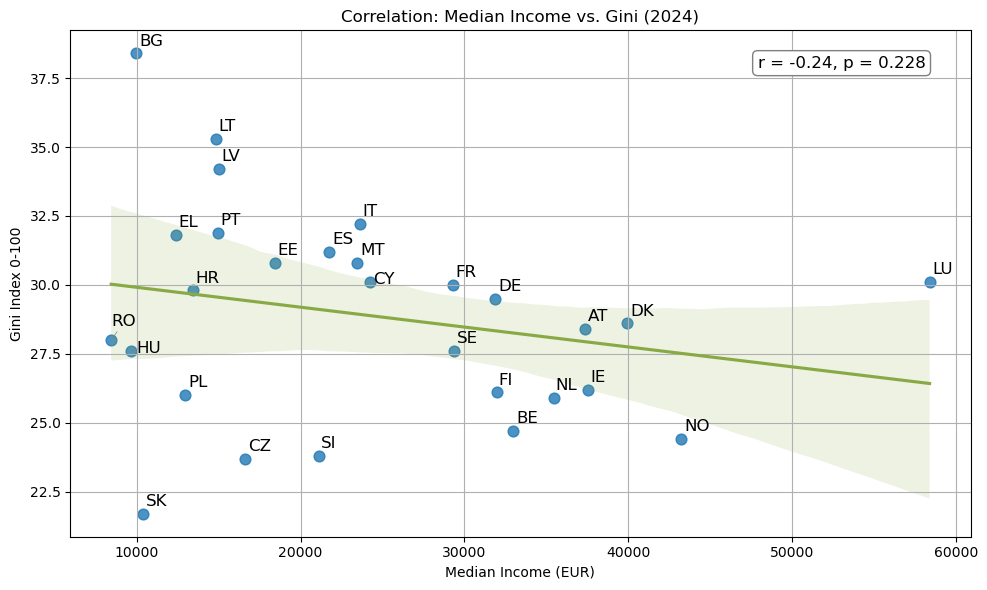

In [323]:
def merge_income_and_gini(df1, df2):
    df = df1.merge(df2[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["value"] * (df["gini"] / 100)
    return df

df_income_1 = merge_income_and_gini(get_data_for_year(df_income_long, 2024), get_data_for_year(df_gini_long,2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["value"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="value", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["value"], row["gini"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Median Income vs. Gini ({year})")
plt.xlabel("Median Income (EUR)")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()

plt.savefig("income_gini_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### Unemployment in Europe
The following plots show the unemployment map, the correlation beween unemployment and gini index (inequiety)

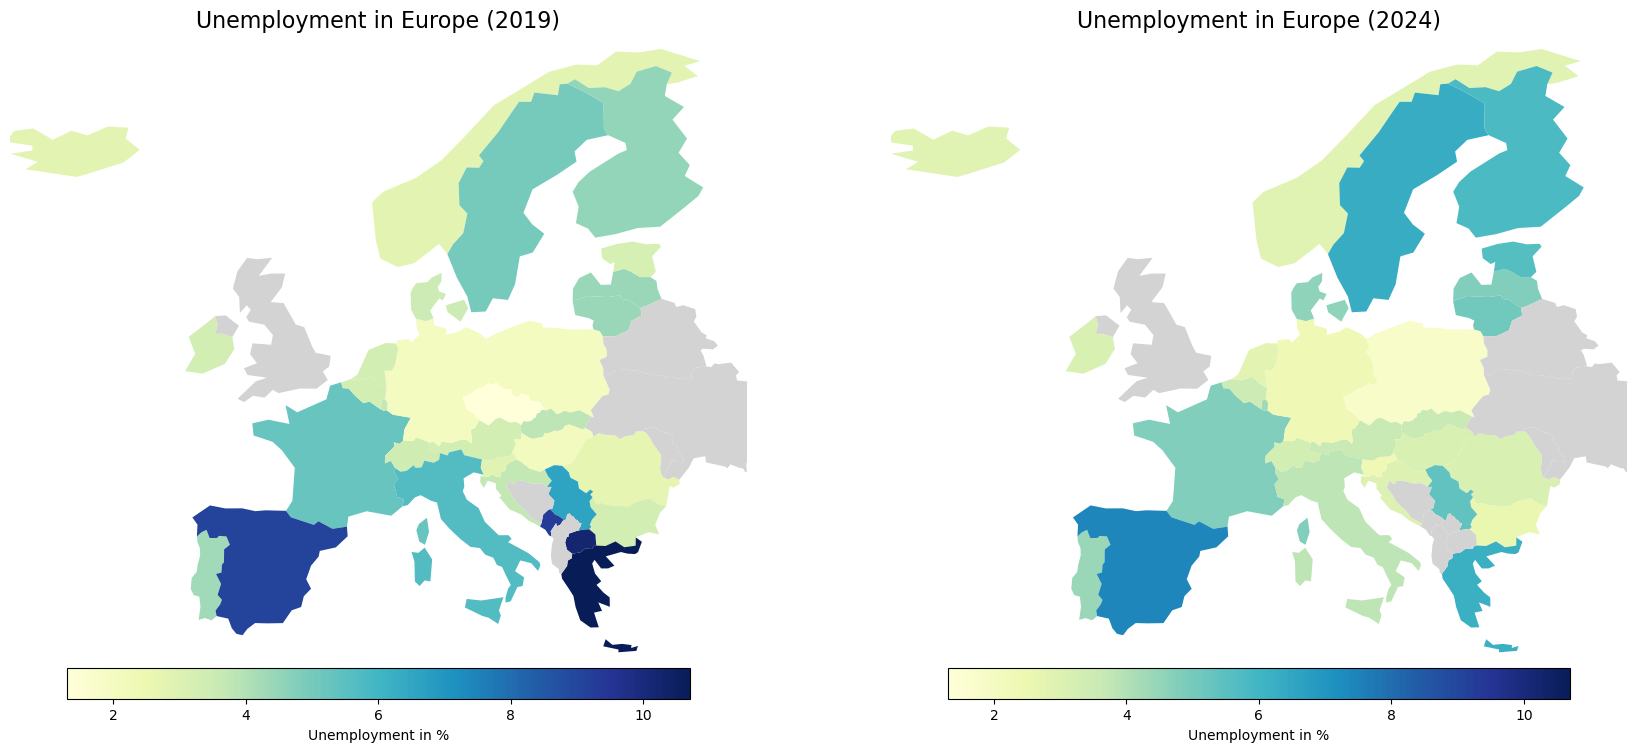

In [317]:
df_1 = get_data_for_year(df_unemp_long, 2019)
df_2 = get_data_for_year(df_unemp_long, 2024)

df_1["unemp"] = df_1["unemp"].astype(str).str.replace(",", ".").astype(float)
df_2["unemp"] = df_2["unemp"].astype(str).str.replace(",", ".").astype(float)

combined_values = pd.concat([df_1["unemp"], df_2["unemp"]])
vmin = combined_values.min()
vmax = combined_values.max()

# Merge with geo data
map_1 = europe.merge(df_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="unemp",
        ax=ax,
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Unemployment in %",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Unemployment in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.savefig("unemp_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

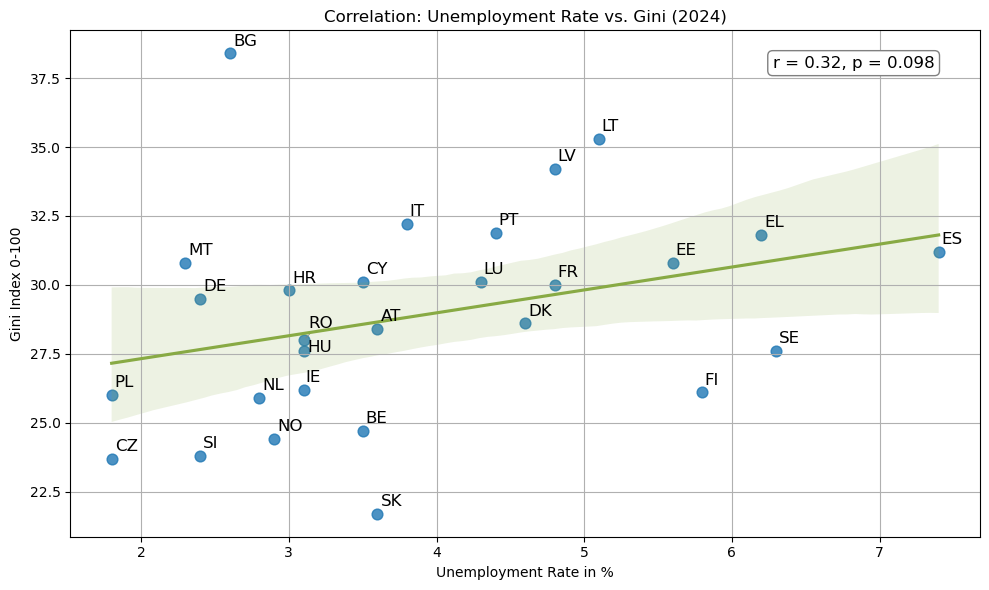

In [318]:
def merge_unemp_and_gini(income_df, cost_df):
    df = income_df.merge(cost_df[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["unemp"] * (df["gini"] / 100)
    return df

df_income_1 = merge_unemp_and_gini(get_data_for_year(df_unemp_long, 2024), get_data_for_year(df_gini_long, 2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["unemp"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="unemp", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["unemp"], row["gini"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Unemployment Rate vs. Gini ({year})")
plt.xlabel("Unemployment Rate in %")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()
plt.savefig("corr_unemp_gini_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### Poverty Plots
The first plot shows poverty maps of europe

The next shows the correaltion of poverty and gini in 2024

Followed by the correaltion of poverty and gini in 10 years from 2015 to 2024

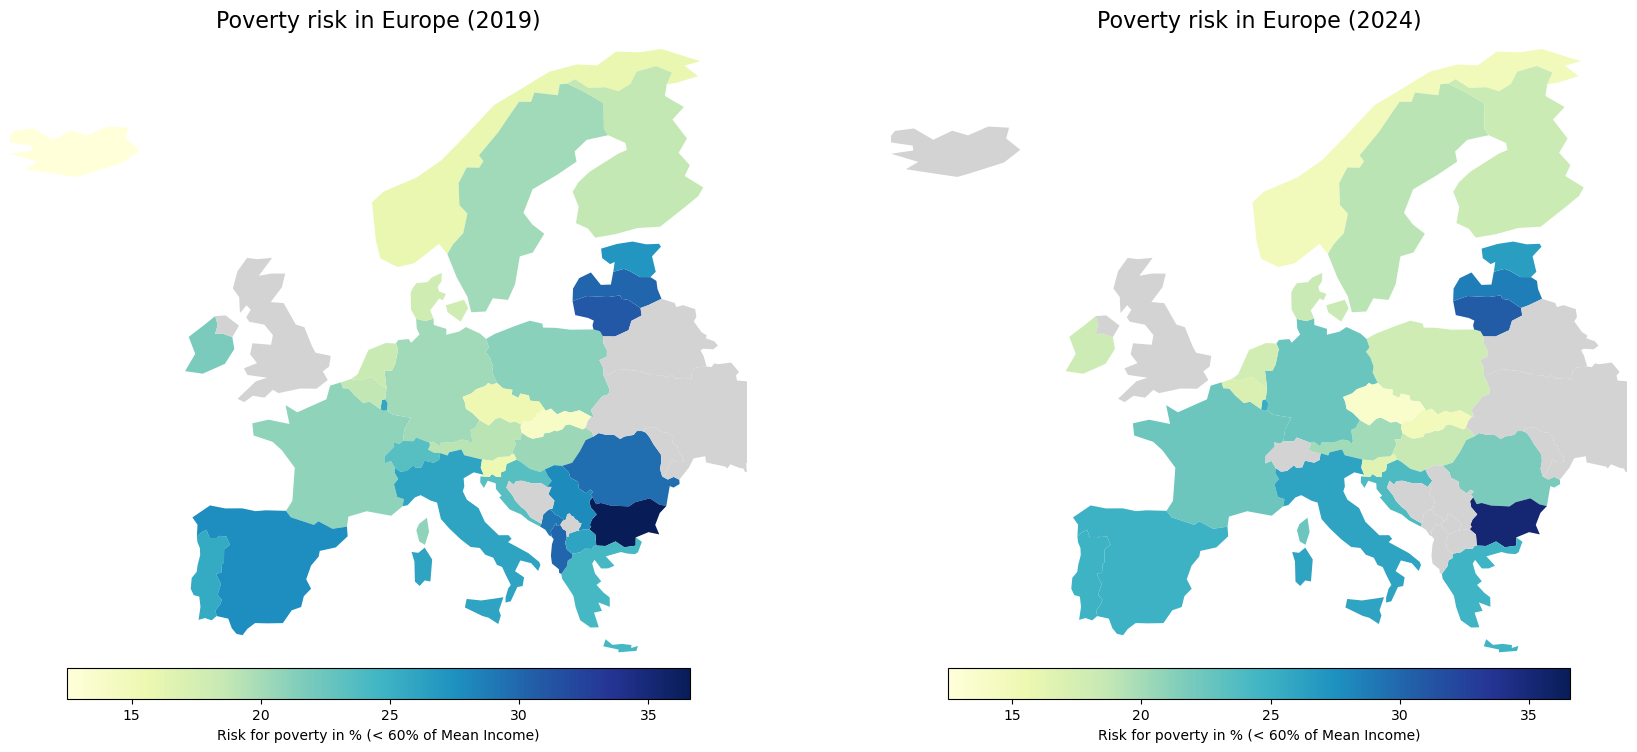

In [319]:
df_1 = get_data_for_year(df_poverty_long, 2019)
df_2 = get_data_for_year(df_poverty_long, 2024)

df_1["pov"] = df_1["pov"].astype(str).str.replace(",", ".").astype(float)
df_2["pov"] = df_2["pov"].astype(str).str.replace(",", ".").astype(float)

combined_values = pd.concat([df_1["pov"], df_2["pov"]])
vmin = combined_values.min()
vmax = combined_values.max()

# Merge with geo data
map_1 = europe.merge(df_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="pov",
        ax=ax,
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Risk for poverty in % (< 60% of Mean Income)",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Poverty risk in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()

plt.savefig("pov_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

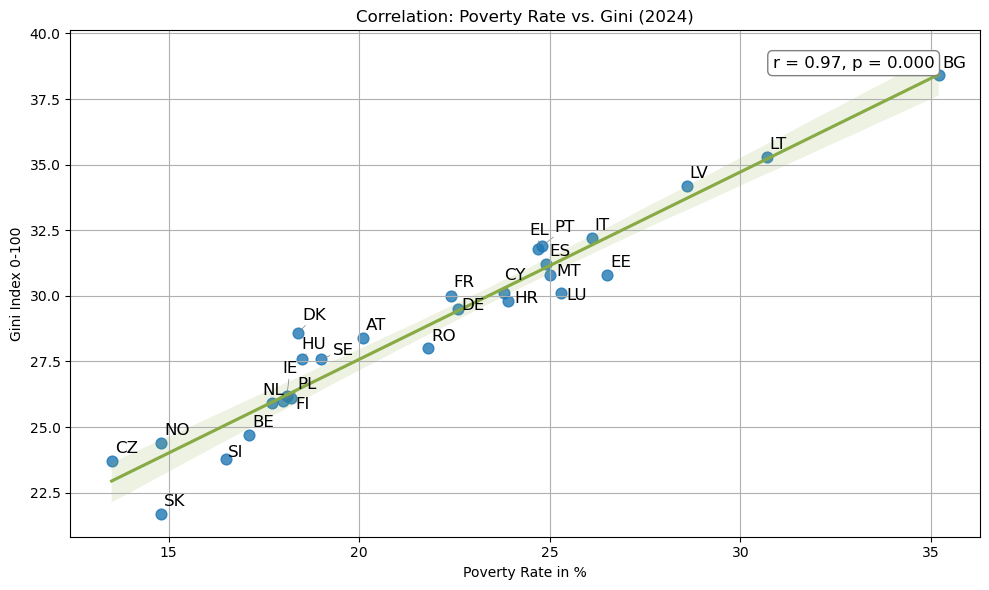

In [320]:
def merge_poverty_and_gini(income_df, cost_df):
    df = income_df.merge(cost_df[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["pov"] * (df["gini"] / 100)
    return df

df_income_1 = merge_poverty_and_gini(get_data_for_year(df_poverty_long, 2024), get_data_for_year(df_gini_long, 2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["pov"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="pov", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["pov"], row["gini"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Poverty Rate vs. Gini ({year})")
plt.xlabel("Poverty Rate in %")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()

plt.savefig("corr_pov_gini_2024.png", dpi=300, bbox_inches="tight")
plt.show()

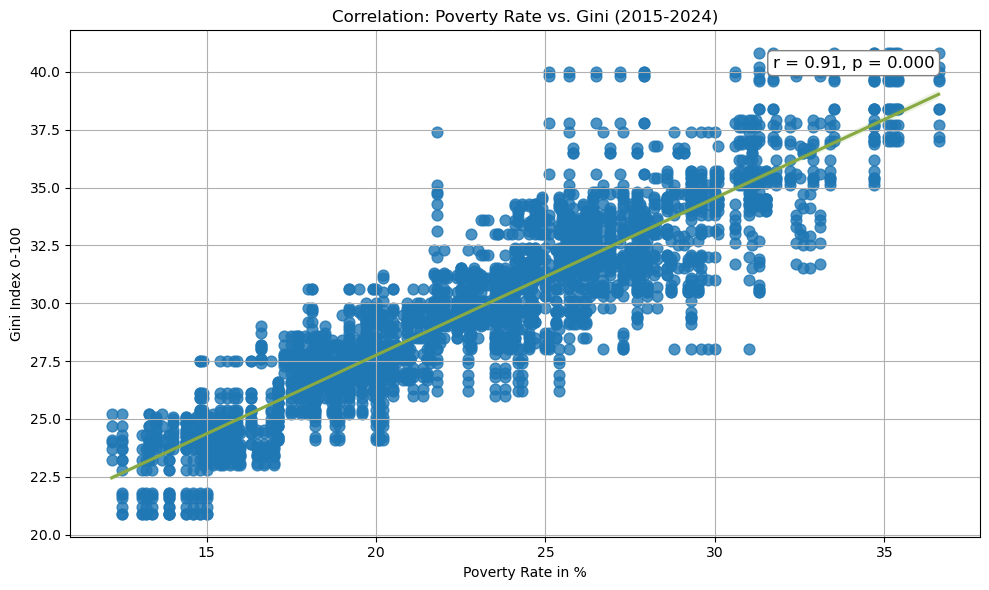

In [321]:
def merge_poverty_and_gini(income_df, cost_df):
    df = income_df.merge(cost_df[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["pov"] * (df["gini"] / 100)
    return df

df_income_1 = merge_poverty_and_gini(get_data_for_years(df_poverty_long, 2015,2024), get_data_for_years(df_gini_long, 2015,2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["pov"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="pov", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Poverty Rate vs. Gini (2015-{year})")
plt.xlabel("Poverty Rate in %")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()

plt.savefig("corr_pov_gini_2015_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### Plot of GINI Map in Europe

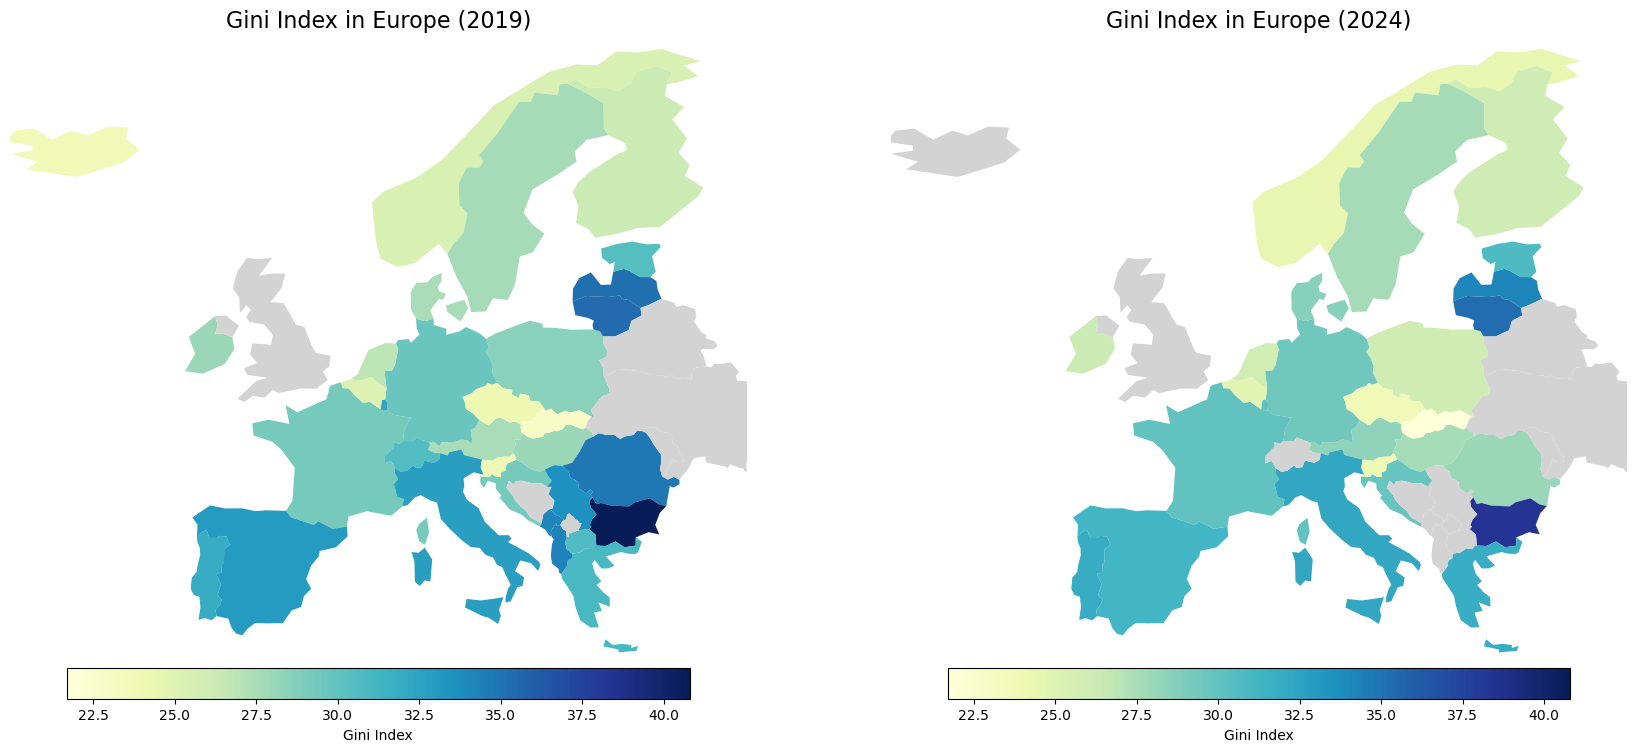

In [322]:
df_1 = get_data_for_year(df_gini_long, 2019)
df_2 = get_data_for_year(df_gini_long, 2024)

df_1["gini"] = df_1["gini"].astype(str).str.replace(",", ".").astype(float)
df_2["gini"] = df_2["gini"].astype(str).str.replace(",", ".").astype(float)

combined_values = pd.concat([df_1["gini"], df_2["gini"]])
vmin = combined_values.min()
vmax = combined_values.max()

# Merge with geo data
map_1 = europe.merge(df_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="gini",
        ax=ax,
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Gini Index",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Gini Index in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()

plt.savefig("gini_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### Heatmap plots
Following plots shows heatmaps for more year comparison in poverty, gini index and living costs

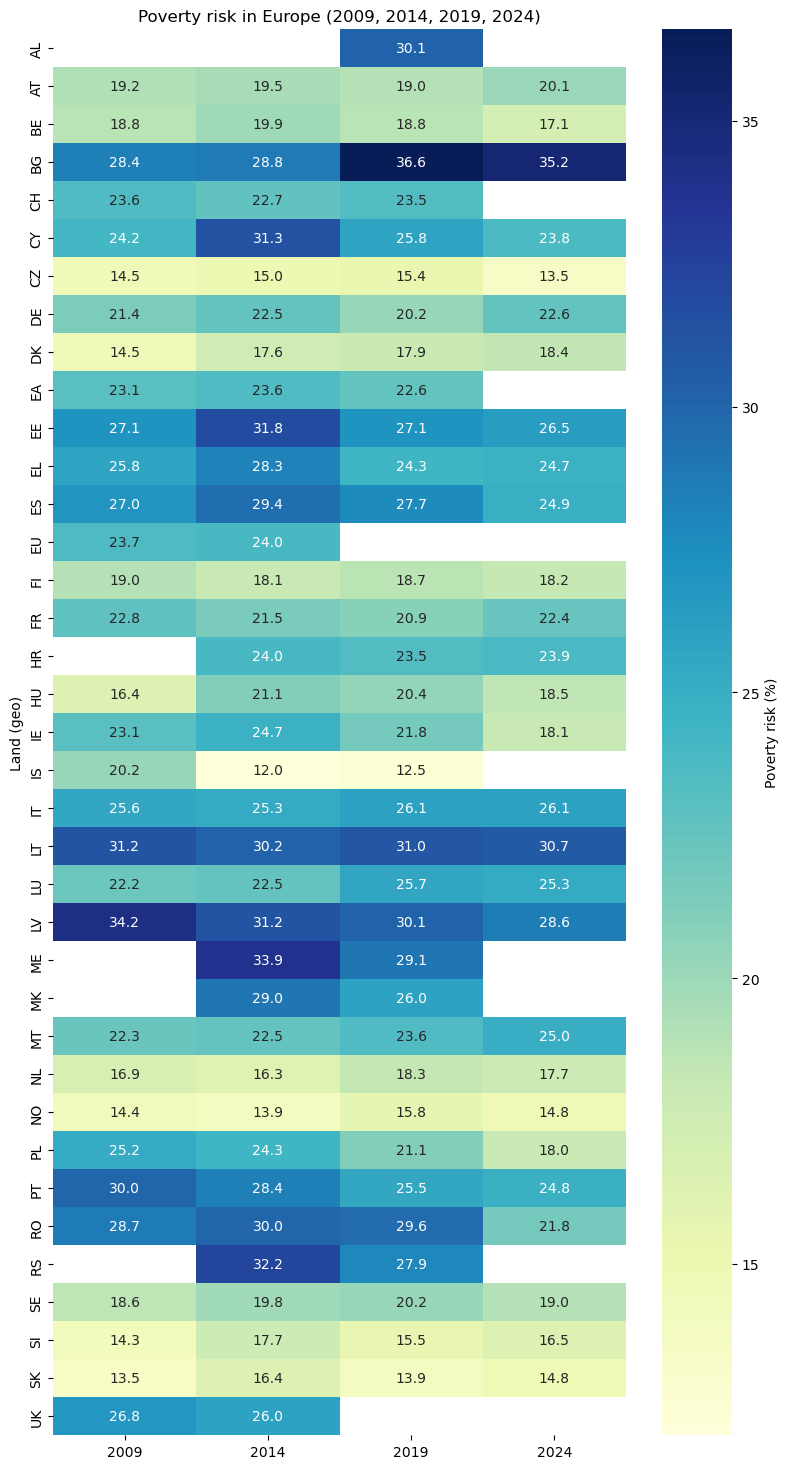

In [324]:
selected_year = 2009, 2014, 2019, 2024
df_year = df_poverty_long[df_poverty_long["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="pov")
heatmap_data = heatmap_data.dropna(how="all")

plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Poverty risk (%)"})

plt.title(f"Poverty risk in Europe {selected_year}")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("heatmap_pov_2009_2024.png", dpi=300, bbox_inches="tight")
plt.show()


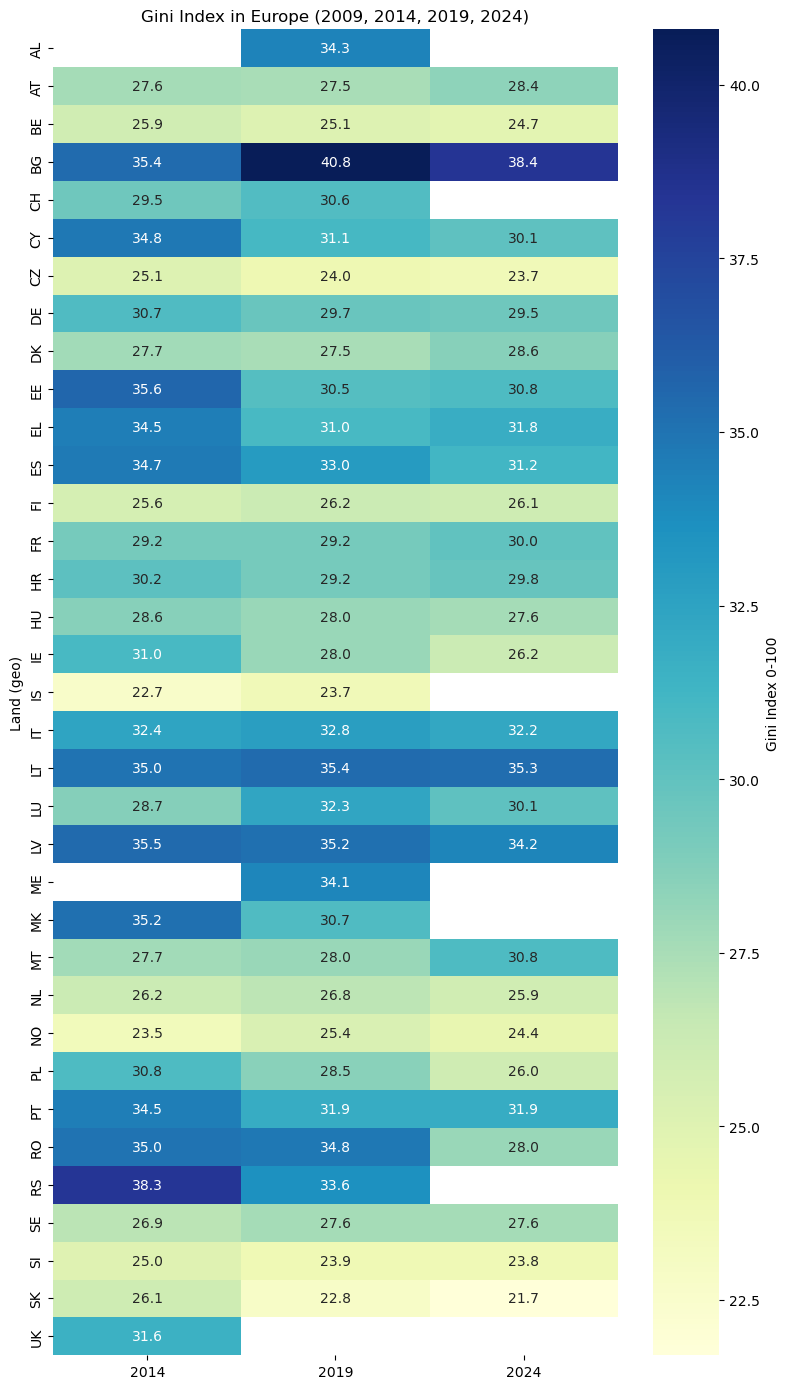

In [328]:
selected_year = 2009, 2014, 2019, 2024
df_year = df_gini_long[df_gini_long["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="gini")
heatmap_data = heatmap_data.dropna(how="all")

plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Gini Index 0-100"})

plt.title(f"Gini Index in Europe {selected_year}")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()

plt.savefig("heatmap_gini_2009_2024.png", dpi=300, bbox_inches="tight")
plt.show()


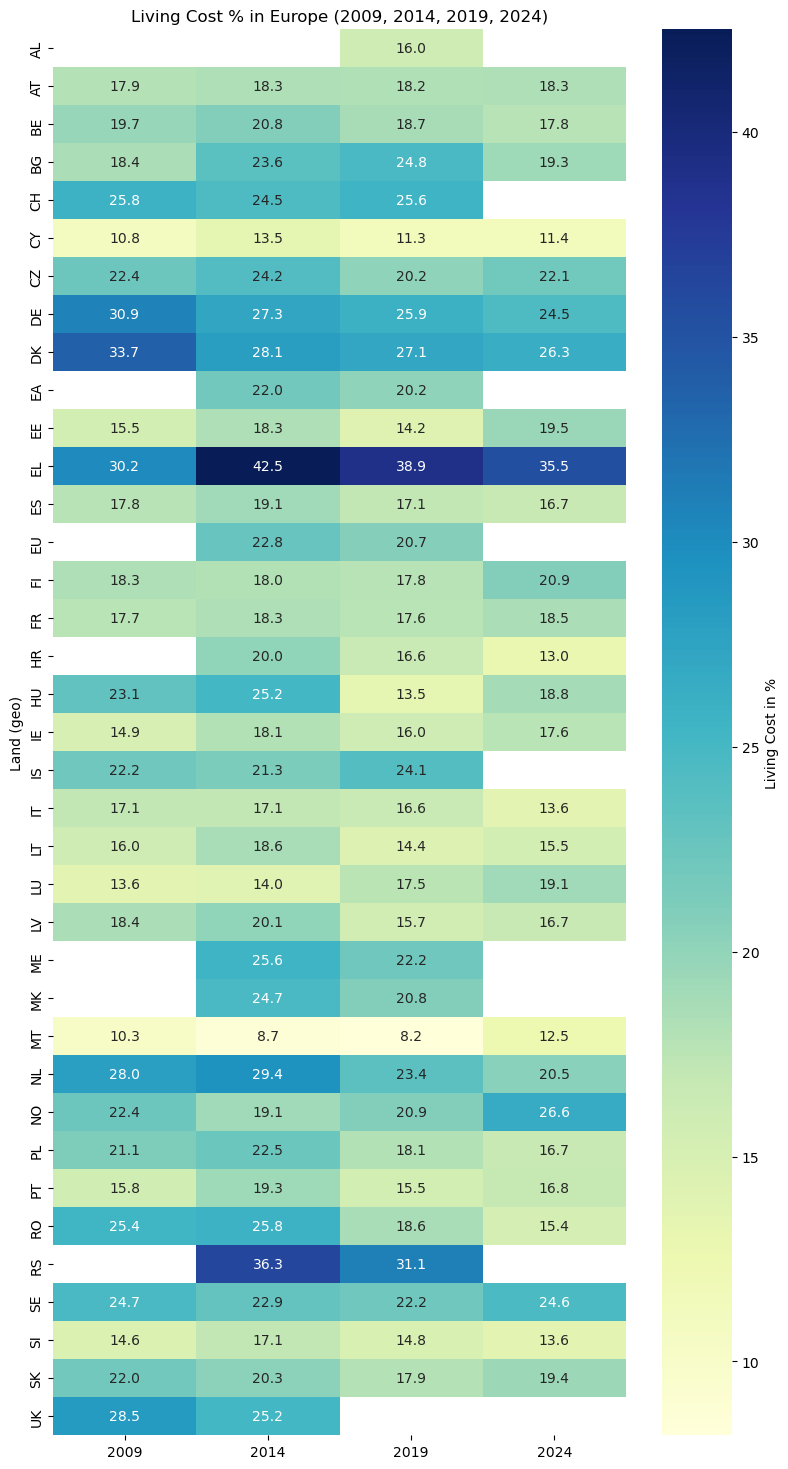

In [330]:
selected_year = 2009, 2014, 2019, 2024
df_year = df_costs_long[df_costs_long["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="cost_share")
heatmap_data = heatmap_data.dropna(how="all")

plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Living Cost in %"})

plt.title(f"Living Cost % in Europe {selected_year}")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()

plt.savefig("heatmap_costs_2009_2024.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
df_orig_mean_median_income = eurostat.get_data_df("ilc_di03")
df_orig_gini_coefficient = eurostat.get_data_df("ilc_di12")
df_orig_at_risk_of_poverty = eurostat.get_data_df("ilc_li02")
df_orig_household_cost_shares = eurostat.get_data_df("ilc_mded01")
df_orig_unemployment_rate = eurostat.get_data_df("une_rt_a")